In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import MaxPooling2D
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import time
import os

# some_file.py
import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, '/Users/tirth/projects/college/DATA-298-MSDAProject/project/Model Training & Evaluation/__helpers')

import evaluation
from model_layers import get_CB_CNN_model
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
batch_size = 64
num_epoch = 50
num_class = 5

In [3]:

def plot_model_history(model_history):
    """
    Plot Accuracy and Loss curves given the model_history
    """
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history['history']['accuracy'])+1),model_history['history']['accuracy'])
    axs[0].plot(range(1,len(model_history['history']['val_accuracy'])+1),model_history['history']['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history['history']['accuracy'])+1, 3))
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history['history']['loss'])+1),model_history['history']['loss'])
    axs[1].plot(range(1,len(model_history['history']['val_loss'])+1),model_history['history']['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history['history']['loss'])+1, 3))
    axs[1].legend(['train', 'val'], loc='best')
    fig.savefig('plot.png')
    plt.show()


In [4]:
def load_dataset(data_dir):
    X = []
    Y = []
    for category in os.listdir(data_dir):
        category_path = os.path.join(data_dir, category)
        for file_name in os.listdir(category_path):
            file_path = os.path.join(category_path, file_name)
            if not os.path.exists(file_path):
              print(file_path)
            image = cv2.imread(file_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            image = cv2.resize(image, (96, 96))
            X.append(image)
            Y.append(category)
    X = np.array(X)
    Y = np.array(Y)
    return X, Y

train_images, train_labels = load_dataset('dataset/train')
test_images, test_labels = load_dataset('dataset/test')

# Normalize the images
train_images = train_images.astype('float32') / 255
test_images = test_images.astype('float32') / 255

# Convert class vectors to binary class matrices
le = LabelEncoder()
train_labels = le.fit_transform(train_labels)
test_labels = le.transform(test_labels)

train_labels = tf.keras.utils.to_categorical(train_labels, num_class)
test_labels = tf.keras.utils.to_categorical(test_labels, num_class)

# Split training dataset into training and validation dataset
validation_split = 0.2
indices = np.random.permutation(train_images.shape[0])
train_indices = indices[:int(train_images.shape[0] * (1 - validation_split))]
val_indices = indices[int(train_images.shape[0] * (1 - validation_split)):]

val_images, val_labels = train_images[val_indices], train_labels[val_indices]
train_images, train_labels = train_images[train_indices], train_labels[train_indices]

In [5]:
le.classes_

array(['back', 'buy', 'more', 'next', 'previous'], dtype='<U8')

In [6]:
train_images[0].shape, val_images[0].shape

((96, 96), (96, 96))

In [7]:
def custom_loss(y_true, y_pred):
    # Define penalty
    penalty = 1

    # Compute cross-entropy loss
    ce_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)

    # Compute penalty for misclassifications
    pred_labels = tf.argmax(y_pred, axis=1)
    true_labels = tf.argmax(y_true, axis=1)
    incorrect_preds = tf.not_equal(pred_labels, true_labels)
    penalty_loss = tf.cast(incorrect_preds, tf.float32) * penalty

    # Compute total loss
    total_loss = ce_loss + penalty_loss

    return total_loss

In [8]:

# Create the model
model = get_CB_CNN_model(num_class)
model.compile(loss=custom_loss, optimizer=Adam(learning_rate=0.00001, decay=1e-6),metrics=['accuracy'])

Metal device set to: Apple M1 Max

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 92, 92, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 46, 46, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 44, 44, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 22, 22, 128)      0         
 2D)                                                    

In [10]:
model_info = None
model.load_weights('model_CB-CNN.h5')

In [11]:
model_info = None
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
try:
  model.load_weights('model_CB-CNN.h5')
except:
  start_time = time.time()
  model_info = model.fit(
            train_images,
            train_labels,
            epochs=num_epoch,
            batch_size=batch_size,
            callbacks=[early_stopping],
            validation_data=(val_images, val_labels))
  end_time = time.time()
  print('Training Time: ', end_time-start_time)
  model.save_weights('model_CB-CNN.h5')
  np.save('history.npy', model_info.history)

In [12]:
start_time = time.time()
model.evaluate(test_images, test_labels)
end_time = time.time()
print('Evaluation Time: ', end_time-start_time)

115/115 [==============================] - 3s 14ms/step - loss: 0.0152 - accuracy: 0.9981
Evaluation Time:  3.1628220081329346


In [13]:
start_time = time.time()
Y_pred = model.predict(test_images)
end_time = time.time()
print(f'Testing Time for {len(test_images)} images: ', end_time-start_time)
y_pred = np.argmax(Y_pred, axis=1)

test_labels_t = np.argmax(test_labels, axis=1)
print('y_pred', y_pred[0])
print('y_actual', test_labels_t[0])

Testing Time for 3652 images:  1.1624667644500732
y_pred 3
y_actual 3


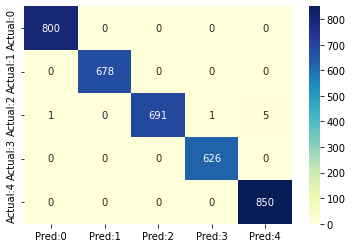

          Pred:0  Pred:1  Pred:2  Pred:3  Pred:4
Actual:0     800       0       0       0       0
Actual:1       0     678       0       0       0
Actual:2       1       0     691       1       5
Actual:3       0       0       0     626       0
Actual:4       0       0       0       0     850
              precision    recall  f1-score   support

        back       1.00      1.00      1.00       801
         buy       1.00      1.00      1.00       678
        more       0.99      1.00      0.99       691
        next       1.00      1.00      1.00       627
    previous       1.00      0.99      1.00       855

    accuracy                           1.00      3652
   macro avg       1.00      1.00      1.00      3652
weighted avg       1.00      1.00      1.00      3652

Accuracy of the test set:  0.9980832420591457
Cohen Kappa Value:  0.9975962501351663
Percent Back correctly predicted:  100.0
Percent Buy correctly predicted:  100.0
Percent More correctly predicted:  98.9971346704871

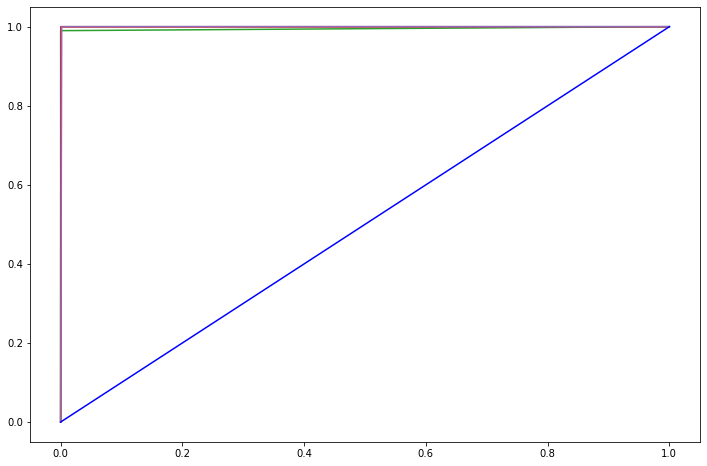

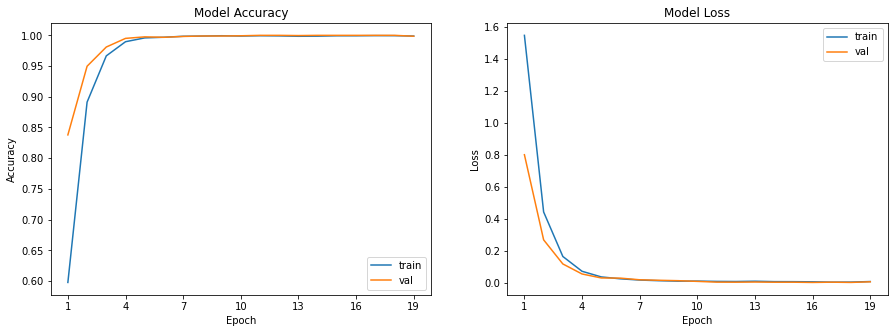

In [14]:
evaluation.print_performance(y_pred, test_labels_t)
evaluation.multiclass_roc_auc_score(test_labels_t, y_pred)

g = {}
model_info = { 'history': np.load('history.npy', allow_pickle=True).item() }


plot_model_history(model_info)